In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import networkx as nx
from collections import Counter
from collections import defaultdict
import json
from google.colab import drive
from community import best_partition, modularity
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
edge_path = '/content/drive/My Drive/Network Codes/datasets/facebook/musae_facebook_edges.csv'
feature_path = '/content/drive/My Drive/Network Codes/datasets/facebook/musae_facebook_features.json'
label_path = '/content/drive/My Drive/Network Codes/datasets/facebook/musae_facebook_target.csv'

In [4]:
with open(edge_path, 'r') as f:
    edges = []
    next(f)
    for line in f:
        u,v = line.strip().split(',')
        edges.append([int(u),int(v)])

features = {int(k) : v for k,v in json.loads(open(feature_path).read()).items()}
targets = pd.read_csv(label_path)


n_edges = len(edges)
n_features = len(features)
n_targets = len(targets)
print('Number of edges: {}, Number oof features: {}, Number of targets: {}'.format(n_edges,n_features,n_targets))

Number of edges: 171002, Number oof features: 22470, Number of targets: 22470


**Type of nodes**

In [5]:
targets.page_type.unique().tolist()

['tvshow', 'government', 'company', 'politician']

**Create Graph**

In [0]:
G = nx.Graph()
G.add_nodes_from(np.arange(n_features,dtype = 'int'))
G.add_edges_from(edges)

for i, row in targets.iterrows():
    G.nodes[row['id']]['facebook_id'] = row['facebook_id']
    G.nodes[row['id']]['page_name'] = row['page_name']
    G.nodes[row['id']]['page_type'] = row['page_type']

In [0]:
def cCDF(data,norm = False,label = None):

    '''
        Plot cCDF

        cCDF(deg_dist,norm = norm,label = label)
        
        Parameters:
        --------
            data: 2d numpy array, with 
                1st column as values
                2nd column as frequency of value

            norm:
                whether to normalized data, bool

        Returns
        --------
        None
    '''

    # sort index by ascending order
    sorted_data = data[data[:,0].argsort()]

    # cumulative sum
    cdf = sorted_data[:,1].cumsum()

    # complementary
    ccdf = (cdf[-1] - cdf)

    if norm:
        ccdf = ccdf/cdf[-1]

    # plot values vs cCDF
    plt.loglog(sorted_data[:,0],ccdf,linestyle = '', marker = '.',markersize = 15, alpha = .7,label = label)
    plt.grid(True,linestyle = '--',color = 'gray')
    plt.title('cCDF loglog plot')
    plt.xlabel('Value')
    plt.ylabel('P(x>=d)')

    if label is not None:
        plt.legend()


def loglog_dist(data, norm=True, label = None):

    '''
        loglog_dist(deg_dist,norm=False,label = label)
    '''


    if norm:
        data[:,1] = data[:,1] / data[:,1].sum()
    plt.loglog(data[:,0],data[:,1],linestyle = '',marker = '.',markersize = 15,alpha = .7,label = label)
    plt.grid(True,linestyle = '--',color = 'gray')
    plt.title('Distribution loglog plot')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    if label is not None:
        plt.legend()

def power_law_plot(data,norm = True,label = None):

    '''
        Generate loglog plot of data distribution and cCDF

    '''
    deg_dist = np.array([[k,v] for k,v in Counter(data.values()).items()])

    plt.subplot(1,2,1)
    loglog_dist(deg_dist,norm=False,label = label)

    plt.subplot(1,2,2)
    cCDF(deg_dist,norm = norm,label = label)

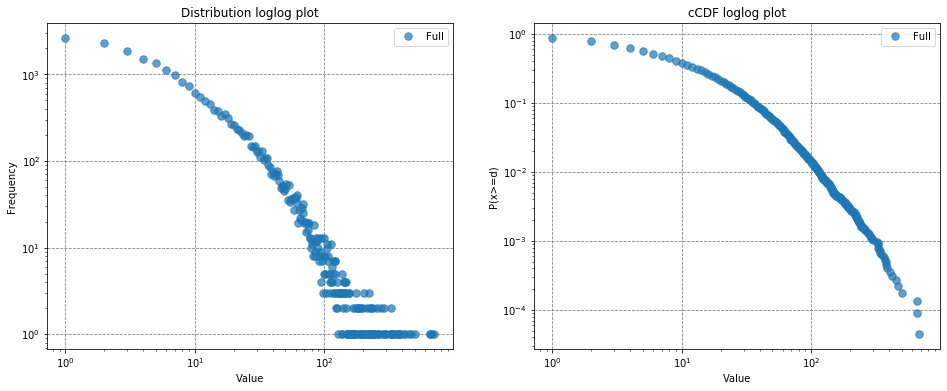

In [10]:
figsize(16,6)
power_law_plot(dict(nx.degree(G)),norm = True,label = 'Full')

**Degree distribution for diffeerent type of nodes**

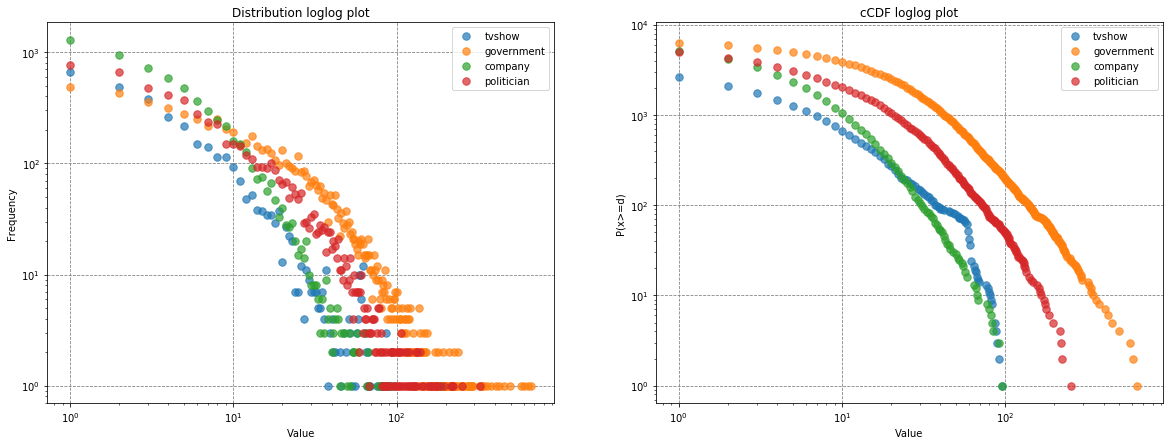

In [11]:
cat_nodes = defaultdict(list) 
for n,d in G.nodes(data = True):
    cat_nodes[d['page_type']].append(n)

figsize(20,7)
plt.subplot(1,2,1)
for k,v in cat_nodes.items():
    s = G.subgraph(v)
    deg_dist = np.array([[k,v] for k,v in Counter(dict(nx.degree(s)).values()).items()])
    loglog_dist(deg_dist,norm = False,label = k)

plt.subplot(1,2,2)
for k,v in cat_nodes.items():
    s = G.subgraph(v)
    deg_dist = np.array([[k,v] for k,v in Counter(dict(nx.degree(s)).values()).items()])
    cCDF(deg_dist,norm = False,label = k)
plt.show()

In [12]:
for k,v in cat_nodes.items():
    s = G.subgraph(v)
    print('Type: {}, Value: {}'.format(k, nx.assortativity.degree_assortativity_coefficient(s)))

Type: tvshow, Value: 0.6320543796840544
Type: government, Value: 0.0240331967828739
Type: company, Value: 0.02853380927225508
Type: politician, Value: -0.005407806763606469


**Slight degree assotative**

In [13]:
nx.assortativity.degree_assortativity_coefficient(G)

0.08505802105736317

**Page type show strong assortativity**

In [14]:
nx.assortativity.attribute_assortativity_coefficient(G,'page_type')

0.8207604936489163

In [0]:
avg_nei_degree = np.array([[G.degree(n),np.mean([G.degree(nei) for nei in G.neighbors(n)])] for n in G.nodes()])

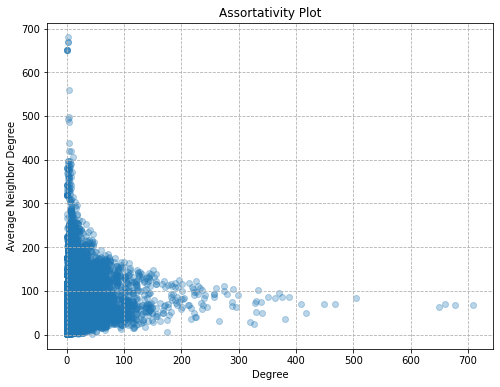

In [16]:
figsize(8,6)
plt.scatter(avg_nei_degree[:,0],avg_nei_degree[:,1],alpha = .3)
plt.xlabel('Degree')
plt.ylabel('Average Neighbor Degree')
plt.title('Assortativity Plot')
plt.grid(True, linestyle = '--')
plt.show()

In [17]:
attr_assort = defaultdict(list)
for k,v in cat_nodes.items():
    for n in v:
        for nei in G.neighbors(n):
            attr_assort[k].append(G.nodes[nei]['page_type'])

for p_type,nei_types in attr_assort.items():
    print(p_type)
    print(Counter(nei_types).most_common())

tvshow
[('tvshow', 25959), ('company', 2484), ('politician', 1268), ('government', 1208)]
government
[('government', 162707), ('politician', 9245), ('company', 4707), ('tvshow', 1208)]
company
[('company', 40179), ('government', 4707), ('tvshow', 2484), ('politician', 678)]
politician
[('politician', 73800), ('government', 9245), ('tvshow', 1268), ('company', 678)]


In [18]:
super_g = []
for u,v,d in G.edges(data = True):
    super_g.append([G.nodes[u]['page_type'],G.nodes[v]['page_type']])
df = pd.DataFrame(super_g,columns = ['from','to'])
super_map = pd.crosstab(df['from'],df.to)
super_map

to,company,government,politician,tvshow
from,,,,
company,20145,2450,363,1206
government,2257,81367,4581,603
politician,315,4664,36909,588
tvshow,1278,605,680,12991


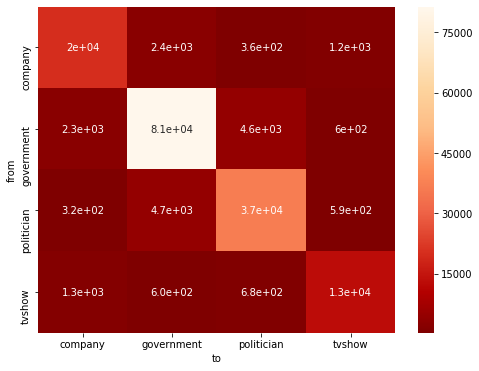

In [19]:
figsize(8,6)
sns.heatmap(super_map,annot = True,cmap = 'OrRd_r')
plt.show()

## Louvain got prettty bad result


**仅预测节点类型，Louvain发现的社群和实际结果基本无关**

In [0]:
partition = best_partition(G)
comm = list(partition.values())
ground_true = [d['page_type'] for n,d in G.nodes(data = True)]

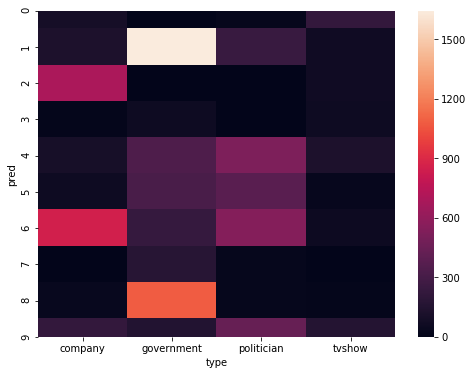

In [0]:
summary = pd.DataFrame(comm,ground_true).reset_index()
summary.columns = ['type','pred']

figsize(8,6)
sns.heatmap(pd.crosstab(summary.type,summary.pred).T.head(10))
plt.show()

In [0]:
pd.crosstab(summary.type,summary.pred).T

type,company,government,politician,tvshow
pred,,,,
0,92,0,21,224
1,122,1643,247,65
2,694,3,0,66
3,17,58,3,59
4,101,337,526,126
5,63,319,382,28
6,848,236,550,56
7,1,169,25,0
8,35,1079,25,16


In [0]:
nei_type = [[n,G.nodes[nei]['page_type']]  for n in G.nodes() for nei in G.neighbors(n)]
feat = pd.DataFrame(np.array(nei_type),columns = ['node','nei_type']).\
pivot_table(index = 'node',columns = 'nei_type',values = 'node', aggfunc = lambda x:len(x)).fillna(0).reset_index()
feat.node = feat.node.astype('int64')
feat.columns = ['node', 'company', 'government', 'politician', 'tvshow']
feat = feat.merge(pd.DataFrame(G.degree(),columns = ['node','degree']),on = 'node',how = 'inner').\
merge(targets[['id','page_type']],left_on = 'node',right_on = 'id',how = 'inner')
feat.drop('id',axis = 1,inplace = True)
targets = pd.get_dummies(feat.page_type)

In [0]:
X = feat[['company','government','politician','tvshow','degree']].values
Y = targets.values

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
lr = OneVsRestClassifier(LogisticRegression())

In [0]:
lr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [0]:
preds = lr.predict(X_test)
preds = np.argmax(preds,axis = 1)
ground_true = np.argmax(y_test,axis = 1)

In [0]:
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix

In [0]:
accuracy_score(ground_true,preds)

0.9049483802064792

In [0]:
print(classification_report(ground_true,preds))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1621
           1       0.96      0.86      0.90      1720
           2       0.96      0.90      0.93      1443
           3       0.95      0.89      0.92       834

    accuracy                           0.90      5618
   macro avg       0.92      0.90      0.91      5618
weighted avg       0.91      0.90      0.91      5618

